In [21]:
import numpy as np
from dobbel import dobbellogger
from help_functies import *
from calibrator3 import calibrate
import matplotlib.pyplot as plt
import pandas as pd
dob = dobbellogger()

In [ ]:
q_rot = np.array([0.23289724, 0.6497377, 0.66263071, -0.2907238])
cali = calibrate(dob, 10, 1, 400, 2, 125, q_rot)
acc_std = cali['acc std']
gyro_std = cali['gyro std']
print(cali)

Leg de dobbelsteen met nummer  1  boven
Wacht 1 secondes
Logging data for 10s


In [2]:
cali = {'gyro bias': np.array([ 0.4494553 , -0.12481477,  0.05589055]), 'gyro std': np.array([0.04623529, 0.06378063, 0.05948078]), 'acc values': np.array([ 0.99333502, -1.00794565,  1.00001939, -1.00483598,  1.02605969, -1.01022587]), 'acc std': np.array([0.001073  , 0.0011066 , 0.00117693, 0.00233057, 0.00178357, 0.00134386])}
q_rot = np.array([-0.22758238, -0.66122331, -0.6738042, 0.23870041])
acc_std = cali['acc std']
gyro_std = cali['gyro std']

In [3]:
dob.connect()
dob.log(5, 100, 4, 2000)
dob.download()
data = dob.datadf

Logging data for 5s
Done! The data is located in self.datadf


In [4]:
# Deze code niet vaker dan 1 keer uitvoeren!
data = remove_nan(data)
data = rotate_data(data, q_rot)
data = remove_bias(data, cali)

In [5]:
data.head(2000)

,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
0,0.0,-0.015697,-0.004272,1.016379,-0.082308,0.366601,0.137138
1,11.0,-0.014776,-0.001248,1.027024,-0.079439,-0.137703,-0.007093
2,21.0,-0.015330,-0.003601,1.022591,0.044120,-0.022390,0.133513
3,31.0,-0.014476,-0.003021,1.022894,-0.022746,0.129771,-0.064730
4,42.0,-0.013862,-0.002711,1.023256,0.042233,-0.012647,0.047854
...,...,...,...,...,...,...,...
509,4938.0,-0.015578,-0.004154,1.022108,-0.019519,0.072320,0.058879
510,4949.0,-0.014142,-0.004399,1.020598,-0.080477,0.071611,0.060141
511,4959.0,-0.015705,-0.005351,1.021208,-0.018726,-0.013355,0.049117
512,4969.0,-0.015088,-0.003749,1.022399,-0.017385,-0.061064,0.087065


In [6]:
for column in data.columns:
    print(column, np.mean(data[column]))

timestamp 2488.826848249027
x_acc -0.01542114621763971
y_acc -0.004103978000597313
z_acc 1.0223201089790657
x_gyro 0.021773671878891426
y_gyro 0.007731445343966998
z_gyro -0.005320665399913682


In [22]:
data = pd.read_csv('yapa data.csv')

In [23]:
y11 = np.array([np.mean(data['x_acc'][0:10]), np.mean(data['y_acc'][0:10]), np.mean(data['z_acc'][0:10])])
gb = y11 / np.linalg.norm(y11)
gn = np.array([0, 0, 1])
mn = np.array([1, 0, 0])
ymb= np.array([1, 2, 3])
mb = np.array([1, 0, 0]) #np.cross(gb, np.cross(ymb / np.linalg.norm(ymb), gb))

A = - np.matmul(left_quat_mul(np.array([0, *gn])), right_quat_mul(np.array([0, *gb]))) - np.matmul(left_quat_mul(np.array([0, *mn])), right_quat_mul(np.array([0, *mb])))

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Eigenvalues are sorted in ascending order by np.linalg.eigh, 
# and the corresponding eigenvectors are columns of 'eigenvectors'
max_eigenvalue_index = np.argmax(eigenvalues)
max_eigenvector = eigenvectors[:, max_eigenvalue_index]
q11 = max_eigenvector

In [24]:
print(quaternion_to_euler(max_eigenvector) * 180 / np.pi)
print(gb)

[ 4.03106519e-04  6.10308925e-01 -3.78443354e-02]
[-2.13021936e-02  6.60320864e-04  9.99772864e-01]


In [25]:
q11 = max_eigenvector

dqde = np.array([
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1]
])

sigma_etha = np.array([
    [(np.pi / 9) ** 2, 0, 0],
    [0, (np.pi / 9) ** 2, 0],
    [0, 0, (np.pi / 9) ** 2]
])

P11 = 0.25 * np.matmul(np.matmul(np.matmul(np.matmul(right_quat_mul(q11), dqde), sigma_etha), dqde.T), right_quat_mul(q11))
v1 = np.array([0,0,0])
p1 = np.array([0,0,0])

In [26]:
qtmin1tmin1 = np.reshape(q11, 4)
Ptmin1tmin1 = P11
vtmin1 = v1
ptmin1 = p1

q_list = [qtmin1tmin1]
v_list = [vtmin1]
p_list = [ptmin1]


Q = np.array([
    [gyro_std[0] ** 2, 0, 0],
    [0, gyro_std[1] ** 2, 0],
    [0, 0, gyro_std[2] ** 2]
])

R = 100000 * np.array([
    [acc_std[0] ** 2, 0, 0],
    [0, acc_std[1] ** 2, 0],
    [0, 0, acc_std[2] ** 2],
])

epsilon_list = []
an_list = []
yat_list = []

for i in range(1, len(data['timestamp'])):
    dt = (data['timestamp'][i] - data['timestamp'][i - 1]) / 1000
    gyro_measurement = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]])
    omega = gyro_measurement
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)

    Ftmin1 = right_quat_mul(expq_omega)
    Gtmin1 = - 0.5 * dt * np.matmul(left_quat_mul(qtmin1tmin1), dqde)
    Pttmin1 = np.matmul(np.matmul(Ftmin1, Ptmin1tmin1), Ftmin1.T) + np.matmul(np.matmul(Gtmin1, Q), Gtmin1.T)
    qttmin1 = quat_mul(qtmin1tmin1, expq_omega)
    
    q0, q1, q2, q3 = qttmin1
    H = 2 * np.array([
        [-q2, q3, -q0, q1],
        [q1, q0, q3, q2],
        [2 * q0, 0, 0, 2 * q3]
    ])

    S = np.matmul(np.matmul(H, Pttmin1), H.T) + R
    K = np.matmul(np.matmul(Pttmin1, H.T), np.linalg.inv(S))

    yat = np.array([data['x_acc'][i], data['y_acc'][i], data['z_acc'][i]])
    yat_list.append(yat)
    yattmin1 = rotate_vector(gn, quaternion_conjugate(qttmin1))
    yateps = yat / np.linalg.norm(yat)
    epsilon = yateps - yattmin1
    q_tt_measure = np.reshape(qttmin1, (4, 1)) + np.matmul(K, np.reshape(epsilon, (3, 1)))
    Ptt = Pttmin1 - np.matmul(np.matmul(K, H), Pttmin1)
    qtt = q_tt_measure / ((np.linalg.norm(q_tt_measure)))
    
    an = rotate_vector(yat, np.reshape(qtt, 4)) - gn
    print(an, yat)
    an = an * 9.81
    an_list.append(an)
    vt = vtmin1 + dt * an
    pt = ptmin1 + dt * vtmin1 + 0.5 * an * dt ** 2 

    Ptmin1tmin1 = Ptt
    qtmin1tmin1 = np.reshape(qtt, 4)
    ptmin1 = pt
    vtmin1 = vt

    q_list.append(qtmin1tmin1)
    epsilon_list.append(epsilon)
    p_list.append(ptmin1)
    v_list.append(vtmin1)

[-0.00511725  0.00152394  0.02248226] [-0.02140151  0.00374786  1.02226533]
[-0.00506497 -0.00069077  0.02255987] [-0.02393396  0.00120802  1.0222918 ]
[-0.0024711  -0.00104779  0.02335366] [-2.22002284e-02  5.21943945e-04  1.02311622e+00]
[-0.00241581 -0.00186542  0.02451592] [-2.27713829e-02 -7.43213073e-04  1.02426710e+00]
[-0.00117258 -0.0020097   0.01954526] [-0.02164912 -0.00128669  1.01931723]
[-0.00027717 -0.00156747  0.02243536] [-0.02085794 -0.00109568  1.02222324]
[0.00062651 0.00160505 0.02662258] [-0.01995495  0.0023262   1.02642743]
[-0.00098335  0.00141781  0.0199469 ] [-0.02156048  0.00230784  1.01971784]
[-0.00130023  0.00013995  0.023241  ] [-0.02208681  0.00105612  1.02300289]
[-0.00246836  0.00034093  0.02478012] [-0.02352217  0.00130152  1.02451234]
[-0.00124259 -0.00158793  0.02176646] [-2.23408025e-02 -7.68440929e-04  1.02152389e+00]
[-0.00126288 -0.0016032   0.02194178] [-2.24685739e-02 -9.15646823e-04  1.02169638e+00]
[-0.00169855 -0.00211055  0.02272986] [-0.0

In [27]:
ans = np.reshape(np.concatenate(an_list), (int(len(an_list)), 3))
for i in range(3):
    print(np.mean(ans[:,i]))

-0.003868556153375118
-0.00616093970079322
0.217243251872039


In [28]:
for q in q_list[:3]:
    print(quaternion_to_euler(q))

[ 7.03553599e-06  1.06519002e-02 -6.60508255e-04]
[-4.16576342e-06  1.59276149e-02 -2.17494364e-03]
[-1.19347789e-05  1.84546165e-02 -1.85661809e-03]


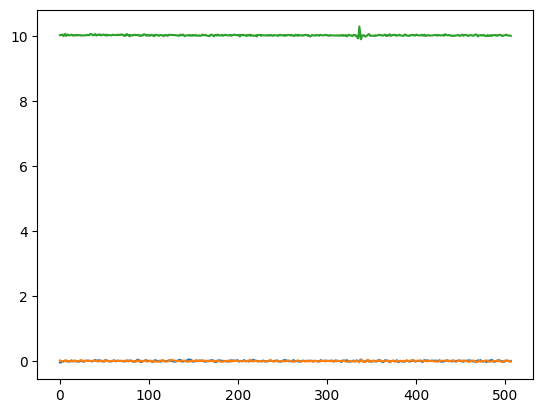

In [29]:
plt.plot(ans[:,0])
plt.plot(ans[:,1])
plt.plot(ans[:,2]+9.81)
plt.show()

In [30]:
yats = np.reshape(np.concatenate(yat_list), (int(len(yat_list)), 3))
for i in range(3):
    print(np.mean(yats[:,i]))

-0.022393716723006617
-0.0004470268534934416
1.0218998659491616


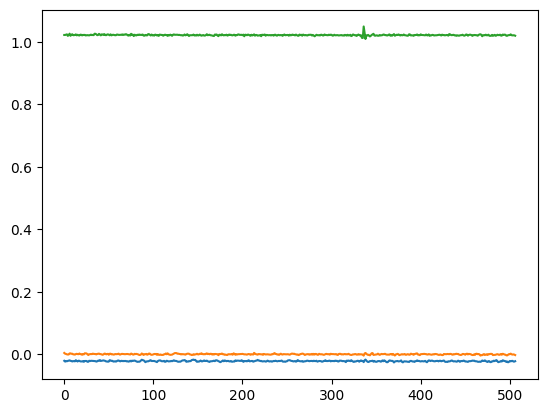

In [31]:
plt.plot(yats[:,0])
plt.plot(yats[:,1])
plt.plot(yats[:,2])

In [32]:
print(np.linalg.norm(np.mean(yats, axis=0)))

1.022145300047206


In [33]:
plot_x = []
plot_y = []
plot_z = []

for q, timestamp in zip(q_list, data['timestamp']):
    euler = quaternion_to_euler(q) * 180 / np.pi
    plot_x.append(euler[0])
    plot_y.append(euler[1])
    plot_z.append(euler[2])

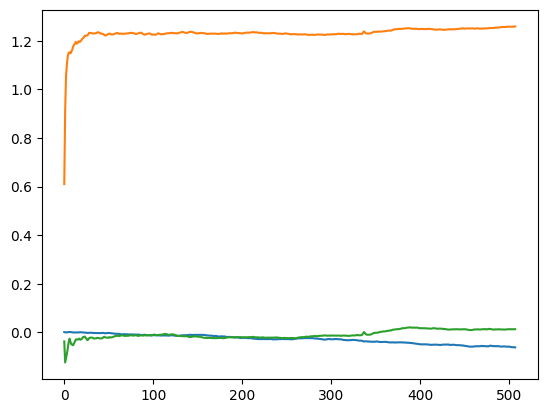

In [34]:
plt.plot(plot_x)
plt.plot(plot_y)
plt.plot(plot_z)

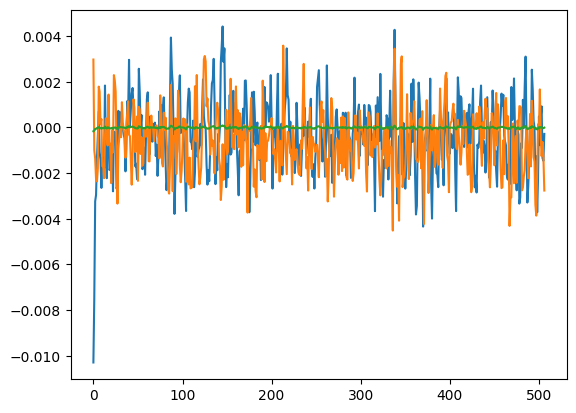

In [35]:
epsilons = np.concatenate(epsilon_list)
epsilons = np.reshape(epsilons, (int(len(epsilons) / 3), 3))

plt.plot(epsilons[:, 0])
plt.plot(epsilons[:, 1])
plt.plot(epsilons[:, 2])

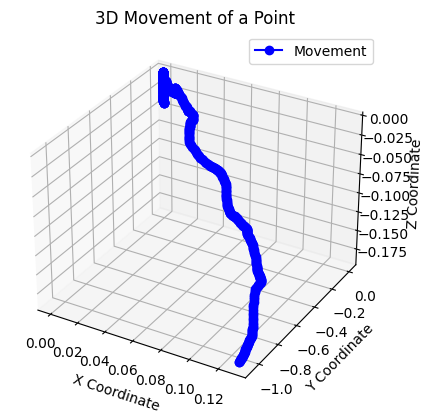

In [17]:
positions = np.reshape(np.concatenate(p_list), (int(len(p_list)), 3))
# Create a new figure for the 3D plot
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot the movement of the point
ax.plot(positions[:,0], positions[:,1], positions[:,2], marker='o', linestyle='-', color='b', label='Movement')

# Set labels for each axis
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

# Set a title
ax.set_title('3D Movement of a Point')

# Add a legend
ax.legend()

# Show the plot
plt.show()

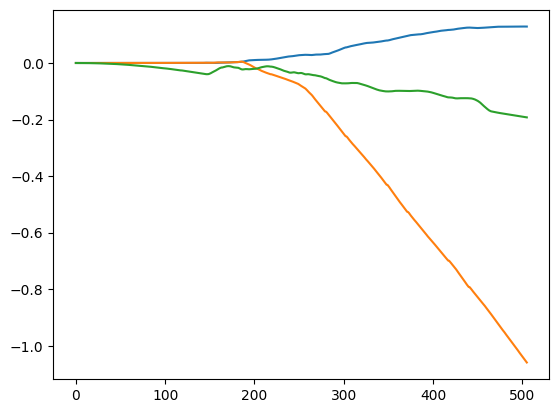

In [18]:
plt.plot(positions[:,0])
plt.plot(positions[:,1])
plt.plot(positions[:,2])
plt.show()